In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [3]:
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from collections import Counter
from tqdm.auto import tqdm

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

!wget $data

--2025-10-20 04:21:29--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.2’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.005s  

2025-10-20 04:21:29 (14.5 MB/s) - ‘course_lead_scoring.csv.2’ saved [80876/80876]



# Data Preparation

In [5]:
df = pd.read_csv('course_lead_scoring.csv')

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
# it looks like data is already low-cased and camel_cased but just in case:

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [8]:
# Are there null or missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [9]:
# categorical = ['lead_source', 'industry', 'employment_status', 'location']
# numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [10]:
# replace missing categorical values with NA and missing numeric values with 0.

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].fillna('na').str.lower()

df.annual_income = pd.to_numeric(df.annual_income, errors='coerce')
df.annual_income = df.annual_income.fillna(0)

In [11]:
# confirm there are no missing values

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [12]:
# we need to split df into train, test, and validation with 60%/20%/20% distribution.
# 1462-(292+292) = 878
# .2 then .33
len(df)

1462

In [13]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution

df_full_train, df_test = train_test_split(df,  test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [14]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [15]:
# double check eveyrthing looks right
df_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
0,events,manufacturing,2,95543.0,unemployed,europe,3,0.78
1,referral,na,1,54924.0,student,south_america,6,0.39
2,organic_search,healthcare,2,77352.0,unemployed,europe,2,0.22
3,paid_ads,other,2,34600.0,employed,south_america,2,0.31
4,paid_ads,education,0,43615.0,unemployed,south_america,2,0.01


# Question 1

In [16]:
numeric_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count','annual_income']

In [17]:
# compute AUC for a single feature, with inversion if needed

def auc_with_possible_inversion(scores, y_true):
    """Compute ROC AUC for a score vector; if < 0.5, invert scores and recompute.
    Returns (final_auc, inverted_flag)."""
    
    s = np.asarray(scores)
    y = np.asarray(y_true)
    
    if np.all(s == s[0]):
        return 0.5, False

    auc = roc_auc_score(y, s)
    if auc < 0.5:
        auc = roc_auc_score(y, -s)
        return auc, True
    else:
        return auc, False


In [18]:
# Compute per-feature AUCs on the training set only

records = []
for col in numeric_features:
    scores = df_train[col].values
    auc, inverted = auc_with_possible_inversion(scores, y_train)
    records.append({
        'feature': col,
        'auc': auc,
        'inverted': inverted,
    })

results_df = pd.DataFrame(records).sort_values('auc', ascending=False).reset_index(drop=True)
results_df

,feature,auc,inverted
0,number_of_courses_viewed,0.763568,False
1,interaction_count,0.738270,False
2,lead_score,0.614499,False
3,annual_income,0.551958,False


# Question 2

In [19]:
categorical_columns

['lead_source', 'industry', 'employment_status', 'location']

In [20]:
numeric_features

['lead_score',
 'number_of_courses_viewed',
 'interaction_count',
 'annual_income']

In [21]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numeric_features].to_dict(orient='records')
val_dict = df_val[categorical_columns + numeric_features].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val   = dv.transform(val_dict)

In [22]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print('AUC:', auc)
print('AUC (rounded to 3 d.p.):', round(auc, 2))

AUC: 0.8171316268814112
AUC (rounded to 3 d.p.): 0.82


# Question 3

In [44]:
thresholds = np.linspace(0, 1, 21)
precisions = []
recalls = []

for t in thresholds:
    y_hat = (y_pred >= t).astype(int)

    TP = np.sum((y_hat == 1) & (y_true == 1))
    FP = np.sum((y_hat == 1) & (y_true == 0))
    FN = np.sum((y_hat == 0) & (y_true == 1))

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0

    precisions.append(prec)
    recalls.append(rec)

In [57]:
precisions = np.array(precisions)
recalls    = np.array(recalls)


diff = np.abs(precisions - recalls).copy()
degenerate = (precisions == 0) & (recalls == 0)
diff[degenerate] = np.inf  # exclude these

idx = int(np.argmin(diff))
t_intersect = float(thresholds[idx])

print("Threshold intersection:", round(t_intersect, 3))

Threshold intersection: 0.65


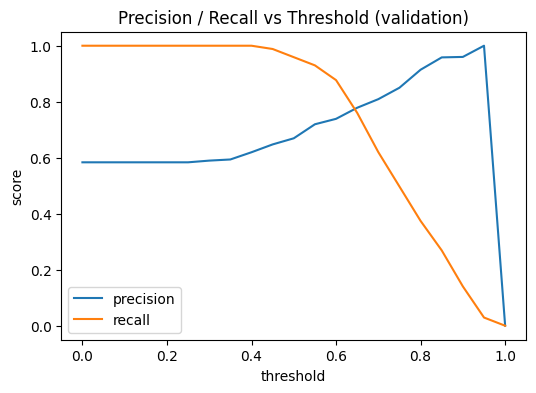

Threshold intersection: 0.65


In [59]:
# Plot

plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.title('Precision / Recall vs Threshold (validation)')
plt.show()

print("Threshold intersection:", round(t_intersect, 3))

# Question 4

In [63]:
y_true = y_val.astype(int)

# don't divide by zero
def safe_precision(TP, FP):
    denom = TP + FP
    return (TP / denom) if denom > 0 else 0.0

def safe_recall(TP, FN):
    denom = TP + FN
    return (TP / denom) if denom > 0 else 0.0

def safe_f1(p, r):
    denom = p + r
    return (2 * p * r / denom) if denom > 0 else 0.0

In [64]:
thresholds = np.linspace(0, 1, 101)
f1s = []

for t in thresholds:
    y_hat = (y_pred >= t).astype(int)

    TP = np.sum((y_hat == 1) & (y_true == 1))
    FP = np.sum((y_hat == 1) & (y_true == 0))
    FN = np.sum((y_hat == 0) & (y_true == 1))

    p = safe_precision(TP, FP)
    r = safe_recall(TP, FN)
    f1s.append(safe_f1(p, r))

f1s = np.array(f1s)
imax = int(np.argmax(f1s))
t_f1_max = float(thresholds[imax])

Q4 — Threshold with maximal F1: 0.57
Q4 — Max F1: 0.812


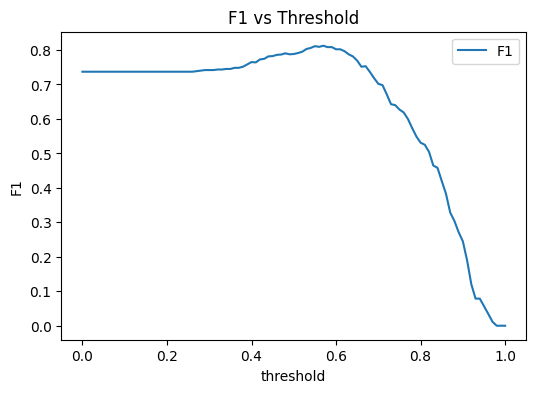

Q4 — Threshold with maximal F1: 0.57
Q4 — Max F1: 0.812


In [68]:
# Plot F1 vs threshold (plain matplotlib per lessons)
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold')
plt.legend()
plt.show()

print("Q4 — Threshold with maximal F1:", round(t_f1_max, 3))
print("Q4 — Max F1:", round(float(f1s[imax]), 3))

# Question 5

In [70]:
def train_on_fold(df_train_fold, y_train_fold, C=1.0):
    dv = DictVectorizer(sparse=False)
    train_dict = df_train_fold[cols_used].to_dict(orient='records')
    X_train_fold = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    return dv, model

In [73]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kf.split(X_full):
    df_tr = X_full.iloc[train_idx].reset_index(drop=True)
    df_va = X_full.iloc[val_idx].reset_index(drop=True)
    y_tr  = y_full[train_idx]
    y_va  = y_full[val_idx]

    dv_fold, model_fold = train_on_fold(df_tr, y_tr, C=1.0)

    val_dict = df_va[cols_used].to_dict(orient='records')
    X_va = dv_fold.transform(val_dict)
    y_pred_va = model_fold.predict_proba(X_va)[:, 1]

    auc = roc_auc_score(y_va, y_pred_va)
    scores.append(auc)

scores = np.array(scores)
print("Scores:", [round(s, 3) for s in scores])
print("Mean:", round(scores.mean(), 3))
print("Std of AUC:", round(scores.std(), 3))


Scores: [np.float64(0.806), np.float64(0.871), np.float64(0.775), np.float64(0.802), np.float64(0.856)]
Mean: 0.822
Std of AUC: 0.036


# Question 6

In [76]:
# Q6: Grid over C values with 5-Fold CV; report mean and std (rounded to 3 d.p.), pick best C

Cs = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cv_auc_for_C(C_value):
    fold_scores = []
    for train_idx, val_idx in kf.split(X_full):
        df_tr = X_full.iloc[train_idx].reset_index(drop=True)
        df_va = X_full.iloc[val_idx].reset_index(drop=True)
        y_tr  = y_full[train_idx]
        y_va  = y_full[val_idx]

        # fold-specific dv and model (lesson methodology)
        dv_fold = DictVectorizer(sparse=False)
        X_tr = dv_fold.fit_transform(df_tr[cols_used].to_dict(orient='records'))
        X_va = dv_fold.transform(df_va[cols_used].to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C_value, max_iter=1000)
        model.fit(X_tr, y_tr)

        y_pred_va = model.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, y_pred_va)
        fold_scores.append(auc)

    fold_scores = np.array(fold_scores)
    return round(fold_scores.mean(), 3), round(fold_scores.std(), 3)

In [86]:
for C in Cs:
    mean_auc, std_auc = cv_auc_for_C(C)
    print(f"C={C}: mean AUC={mean_auc}, std={std_auc}")

C=1e-06: mean AUC=0.56, std=0.024
C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036
